# Importing data


In [45]:
import pandas as pd
import numpy as np
import string
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [46]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
import pandas as pd

data_classic1 = pd.read_csv('/content/people_wiki.csv', sep= ',')
texts1 = data_classic1['text'].values.astype('U')


In [48]:
#preprocessing for wiki people data
nopunc = str.maketrans('', '', string.punctuation)
lem = WordNetLemmatizer()
custom_stopwords = set(stopwords.words("english")+ ["study", "year", "president", "book", 
                                                     "state", "work", "first", "also",
                                                     "united", "member", "served","university","the"])
custom_stopwords = [lem.lemmatize(word) for word in custom_stopwords]

In [49]:
def preprocess(abst_list):
    abstracts =[]
    for line in abst_list:
        line.replace("\n", "")
        line = line.lower()
        line = line.translate(nopunc)
        line = re.sub('[^A-Za-z]', ' ', line)
        new = ' '
        for word in line.split():
            word = lem.lemmatize(word)
            if word not in custom_stopwords and len(word)>3:
                new = new + ' ' + word
        abstracts.append(new)
    return abstracts

In [50]:
texts11 = preprocess(texts1)

In [51]:
data_classic2 = pd.read_csv('/content/pub_abs.csv', sep=",", )
texts2 = data_classic2['Abstract'].values

In [52]:
nopunc = str.maketrans('', '', string.punctuation)
lem = WordNetLemmatizer()
custom_stopwords = set(stopwords.words("english")+ ["study", "group", "patient", "used", 
                                                     "disease", "effect", "method", "also",
                                                     "result", "two", "may","level",
                                                     "participant","treatment","associated"
                                                     "risk", "however","year",
                                                     "the", "this","using", "showed", "analysis"])
custom_stopwords = [lem.lemmatize(word) for word in custom_stopwords]

In [53]:
texts22 = preprocess(texts2)

#Define representation models





We recover the Glove model then convert it into the word2vec format to then use it on our datasets (classic 4 and classic2)

In [54]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [55]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [56]:
tmp_file = 'test_word2vec.txt'
glove_file = 'glove_vectors.txt'
glove2word2vec(glove_file, tmp_file)
glove_model = KeyedVectors.load_word2vec_format(tmp_file)

In [57]:
get_glove_vector = lambda x: glove_model[x] if x in glove_model.vocab else None

In [58]:
import re 

token_pattern = r"(?u)\b\w\w+\b"
token_pattern = re.compile(token_pattern)

In [59]:
import numpy as np
from warnings import warn
def tokenize_re(text, min_len=2):
    tokens = token_pattern.findall(text)
    return [x for x in tokens if len(x) >= min_len]

def static_document_embeddings(word_embedding_func, docs, tokenizer, n_dims=50):
    """
        Given a set of tokenized sentences, compute the mean vector of w2v vectors for each sentence
    """
    doc_vectors = []
    for doc in docs:
        doc = tokenizer(doc)
        word_vectors = []
        for word in doc:
            vector = word_embedding_func(word)
            if vector is not None:
                word_vectors.append(vector)
        if word_vectors:
            doc_vector = np.array(word_vectors).mean(axis=0)
        else:
            warn("Zeros returned. Words not in vocabulary \"{}\"".format(doc), Warning)
            doc_vector = np.array([0] * n_dims)
        
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)

In [60]:
#the creation of glove representations of our datasets (classic1 and classic2)
X_glove = static_document_embeddings(get_glove_vector, texts11, tokenize_re)
x_glove_b= static_document_embeddings(get_glove_vector, texts22, tokenize_re)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: Warning: Zeros returned. Words not in vocabulary "[]"


In [61]:
print("classic1 glove :" , X_glove.shape)
print("classic2 glove :" , x_glove_b.shape)

classic1 glove : (42786, 50)
classic2 glove : (10277, 50)


In [62]:
del glove_model

### Clustering:

---
> In this part, we will apply the clustering on the two on our dataset utilizing glove representation with k-means and see the difference between the two 


In [63]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt

In [64]:
def eval_clustering_2D(x, labels):
    fig, (ax1) = plt.subplots(1)
    ax1.scatter(x[:,0], x[:,1],
                c=labels, edgecolor='none', alpha=1,)

### **wiki people**

Glove

In [65]:
sse = []
list_k = list(range(2,15))

for k in list_k:
    km = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
    km.fit(X_glove)
    sse.append(km.inertia_)


k = 6
k_means = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
k_means.fit(X_glove)



MiniBatchKMeans(max_iter=1000, n_clusters=6, n_init=20, random_state=0)

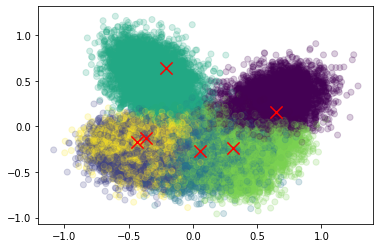

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=0)
reduced_vectors = pca.fit_transform(X_glove)
reduced_clusters = pca.fit_transform(k_means.cluster_centers_)

plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_, alpha=0.2)
plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

In [67]:
def get_top_n_words(corpus, n):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_wordcloud(text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



In [68]:
k_means.labels_

array([3, 4, 5, ..., 3, 2, 0], dtype=int32)

In [71]:
df3 = pd.DataFrame()
df3['labels'] = k_means.labels_
df3['labels'].value_counts()

3    9172
0    7801
4    7303
1    6421
5    6127
2    5962
Name: labels, dtype: int64

In [72]:
df4 = pd.DataFrame()
df4['preprocessed'] = texts11

In [ ]:
from wordcloud import WordCloud
for clus in range (6):
    text =' '
    df2 = df4.loc[df3["labels"]==clus]
    
    #wordcloud
    for abst in df4.preprocessed:
        text += abst
    get_wordcloud(text)
    
    #top10words
    words = []
    for i, j in get_top_n_words(df4["preprocessed"],10):
        words.append(i)
    print ("Top 10 words from cluster",clus,":")
    print (words)


## **PubMed abstracts**

In [74]:
sse = []
list_k = list(range(2,15))

for k in list_k:
    km = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
    km.fit(x_glove_b)
    sse.append(km.inertia_)


k = 6
k_means = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
k_means.fit(x_glove_b)

MiniBatchKMeans(max_iter=1000, n_clusters=6, n_init=20, random_state=0)

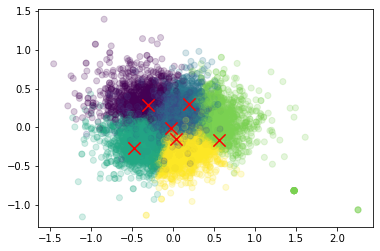

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=0)
reduced_vectors = pca.fit_transform(x_glove_b)
reduced_clusters = pca.fit_transform(k_means.cluster_centers_)

plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_, alpha=0.2)
plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

In [76]:
df = pd.DataFrame()
df['labels'] = k_means.labels_
df['labels'].value_counts()

3    2256
2    2100
5    2039
1    1533
4    1391
0     958
Name: labels, dtype: int64

In [77]:
df1 = pd.DataFrame()
df1['preprocessed'] = texts22

In [ ]:
from wordcloud import WordCloud
for clus in range (6):
    text =' '
    df5 = df.loc[df["labels"]==clus]
    
    #wordcloud
    for abst in df1.preprocessed:
        text += abst
    get_wordcloud(text)
    
    #top10words
    words = []
    for i, j in get_top_n_words(df1["preprocessed"],10):
        words.append(i)
    print ("Top 10 words from cluster",clus,":")
    print (words)